# <center>SAE</center>

To do:
- Description + refs

In [1]:
import torch

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

from geomloss import SamplesLoss 
from tqdm.auto import trange
from sklearn.datasets import make_circles

from sw import sliced_wasserstein

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### MNIST

In [3]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor()#,
                # torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=500, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

### AutoEncoder

In [4]:
class Encoder(nn.Module):
    def __init__(self, num_filter, d=48):
        super().__init__()
        self.num_filter = num_filter
        self.conv1 = nn.Conv2d(1, self.num_filter, 
                               kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(self.num_filter, self.num_filter, 
                               kernel_size=3, padding=1)
        self.pool1 = nn.AvgPool2d(kernel_size=2, padding=0)
        self.conv3 = nn.Conv2d(self.num_filter, self.num_filter*2,
                               kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(self.num_filter*2, self.num_filter*2,
                               kernel_size=3, padding=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, padding=0)
        self.conv5 = nn.Conv2d(self.num_filter*2, self.num_filter*4, 
                               kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(self.num_filter*4, self.num_filter*4,
                               kernel_size=3, padding=1)
        self.pool3 = nn.AvgPool2d(kernel_size=2, padding=1)        
        
        self.fc1 = nn.Linear(int(self.num_filter*4*4*4), 128)
        self.fc2 = nn.Linear(128, d)
                
        
    def forward(self, x):
        if len(x.shape) == 3:
            x = x[None, ...]

        out = F.leaky_relu(self.conv1(x), 0.2)
        out = self.pool1(F.leaky_relu(self.conv2(out), 0.2))
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = self.pool2(F.leaky_relu(self.conv4(out), 0.2))
        out = F.leaky_relu(self.conv5(out), 0.2)
        out = self.pool3(F.leaky_relu(self.conv6(out), 0.2))
        out = out.view(out.size(0), -1)
        out = torch.relu(self.fc1(out))
        return self.fc2(out)
    

class Decoder(nn.Module):
    def __init__(self, num_filter, bottleneck_size=48):
        super().__init__()
        self.num_filter = num_filter

        self.fc4 = nn.Linear(bottleneck_size, 128)
        self.fc5 = nn.Linear(128, self.num_filter*4*4*4)
        
        self.upsample = nn.Upsample(scale_factor=2)
        self.conv1 = nn.Conv2d(self.num_filter*4, self.num_filter*4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(self.num_filter*4, self.num_filter*4, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(self.num_filter*4, self.num_filter*4, kernel_size=3, padding=0)
        self.conv4 = nn.Conv2d(self.num_filter*4, self.num_filter*2, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(self.num_filter*2, self.num_filter*2, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(self.num_filter*2, 1, kernel_size=3, padding=1)
    
    def forward(self, x):
        d = self.num_filter
        out = torch.relu(self.fc5(self.fc4(x)))
        out = out.view(-1, 4*d, 4, 4)
        
        out = F.leaky_relu(self.conv1(self.upsample(out)), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(self.upsample(out)), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        out = F.leaky_relu(self.conv5(self.upsample(out)), 0.2)

        out = torch.sigmoid(self.conv6(out))
        return out
    
    
class AE(nn.Module):
    def __init__(self, input_shape, d=48):
        super().__init__()
        self.encoder = Encoder(input_shape, d)
        self.decoder = Decoder(input_shape, d)
    
    def forward(self, x):
        z = self.encoder(x)        
        y = self.decoder(z)
        return y

In [5]:
## https://github.com/eifuentes/swae-pytorch/blob/763f771c1d4860f71819af48d4f21a8a29a689d5/swae/distributions.py#L38

def rand_ring2d(batch_size):
    """ This function generates 2D samples from a hollowed-cirlce distribution in a 2-dimensional space.
        Args:
            batch_size (int): number of batch samples
        Return:
            torch.Tensor: tensor of size (batch_size, 2)
    """
    circles = make_circles(2 * batch_size, noise=.01)
    z = np.squeeze(circles[0][np.argwhere(circles[1] == 0), :])
    return torch.from_numpy(z).type(torch.FloatTensor)


def rand_circle2d(batch_size):
    """ This function generates 2D samples from a filled-circle distribution in a 2-dimensional space.
        Args:
            batch_size (int): number of batch samples
        Return:
            torch.Tensor: tensor of size (batch_size, 2)
    """
    r = np.random.uniform(size=(batch_size))
    theta = 2 * np.pi * np.random.uniform(size=(batch_size))
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    z = np.array([x, y]).T
    return torch.from_numpy(z).type(torch.FloatTensor)

In [6]:
def val_mnist(model, latent_dim=2, latent_distr="unif"):
    model.eval()

    torch.manual_seed(42)
    r,c = 5,5
    if latent_distr == "unif":
        z = -1+2*torch.rand(r*c, latent_dim, device=device)
    elif latent_distr == "ring":
#         g = torch.randn(n, d, device=device)
#         z = F.normalize(g, p=2, dim=1)
        z = rand_ring2d(r*c).to(device)
    elif latent_distr == "circle":
        z = rand_circle2d(r*c).to(device)
        
    gen_imgs = model.decoder(z).reshape(-1,28,28).detach().cpu()

    cpt = 0
    fig,ax = plt.subplots(r,c)
    for i in range(r):
        for j in range(c):
            ax[i,j].imshow(gen_imgs[cpt],"gray")
            ax[i,j].axis('off')

            cpt += 1
                
    fig.set_size_inches(6, 6)
    plt.tight_layout()
    plt.show()

In [7]:
def plot_latent(model, test_loader):
    model.eval()

    test_encode, test_targets = [], []
    for x_val, y_val in test_loader:
        x_val = x_val.to(device)

        zhat = model.encoder(x_val)
        yhat = model.decoder(zhat)
        test_encode.append(zhat.detach())
        test_targets.append(y_val.detach())
    
    test_encode = torch.cat(test_encode).cpu().numpy()
    test_targets = torch.cat(test_targets).cpu().numpy()
    
    # Distribution of the encoded samples
    z = test_encode
    Y = test_targets

    plt.figure(figsize=(10,10))
    plt.scatter(z[:,0], -z[:,1], c=10*Y, cmap=plt.cm.Spectral)
    plt.xlim([-1.5,1.5])
    plt.ylim([-1.5,1.5])
    plt.show()

In [ ]:
def train(model, optimizer, n_epochs, train_loader, test_loader, latent_distr="unif", plot_val=False):
    pbar = trange(n_epochs)

    losses = []
    val_losses = []

    for e in pbar:
        loss_epoch = 0
        cpt_batch = 0

        for x_batch, _ in train_loader:
            x_batch = x_batch.to(device)

            model.train()

            z_hat = model.encoder(x_batch)
            y_hat = model.decoder(z_hat)

            l = ae_loss(x_batch, y_hat, z_hat, latent_distr)
            l.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_epoch += l.item()/x_batch.size(0)
            cpt_batch += 1

        losses.append(loss_epoch/cpt_batch)

        loss_val_epoch = 0
        cpt_batch = 0

        with torch.no_grad():
            for x_val, _ in test_loader:
                x_val = x_val.to(device)

                model.eval()
                zhat = model.encoder(x_val)
                yhat = model.decoder(zhat)
                val_l = ae_loss(x_val,yhat,zhat,latent_distr)
                loss_val_epoch += val_l.item()/x_val.size(0)
                cpt_batch += 1

            val_losses.append(loss_val_epoch/cpt_batch)

        print(e,losses[-1],val_losses[-1])

        if e%10 == 0 and plot_val:  
            with torch.no_grad():
                model.eval()
                for x_val, _ in test_loader:
                    fig,ax = plt.subplots(1,2,figsize=(10,10))

                    ax[0].imshow(x_val[0][0],"gray")

                    x_val = x_val.to(device)

                    model.eval()
                    yhat = model(x_val[0][0].reshape(-1,28,28))
                    yhat = yhat.reshape(-1,1,28,28)
                    ax[1].imshow(yhat[0][0].cpu().detach().numpy(),"gray")
                    plt.show()

                    break

                plot_latent(model, test_loader)
                
    if plot_val:
        plt.plot(losses, label="Training loss")
        plt.plot(val_losses, label="Validation loss")
        plt.legend()
        plt.show()

### Sinkhorn AutoEncoder

In [11]:
criterion = nn.BCELoss(reduction='mean')
loss_func = SamplesLoss("sinkhorn", blur=0.05,scaling = 0.95,diameter=0.01,debias=True)


def ae_loss(x, y, z, latent_distr="unif"):
    n, d = z.size()
    
    if latent_distr == "unif":
        target_latent = -1+2*torch.rand(n, d, device=device)
    elif latent_distr == "ring":
#         g = torch.randn(n, d, device=device)
#         target_latent = F.normalize(g, p=2, dim=1)
        target_latent = rand_ring2d(n).to(device)
    elif latent_distr == "circle":
        target_latent = rand_circle2d(n).to(device)

    latent_loss = loss_func(z, target_latent)
    reconstruction_loss = criterion(y, x)
    return reconstruction_loss+10.0*latent_loss

  0%|          | 0/101 [00:00<?, ?it/s]

0 0.004508504920701184 0.028775166770734918


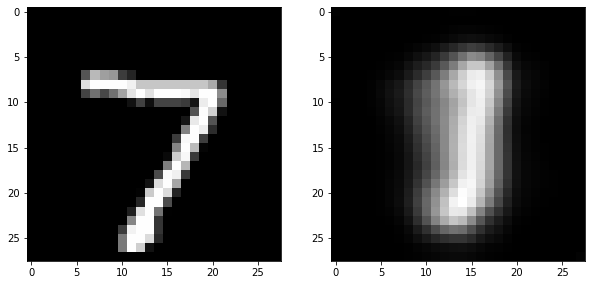

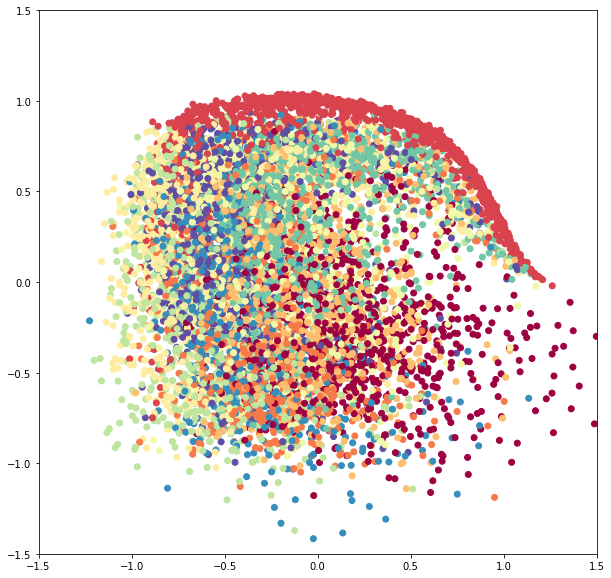

1 0.0005467473069826761 0.027073433676276345
2 0.0004901927627623081 0.027986285493920404
3 0.00047470525080958986 0.025702427739438156
4 0.00046818971037864684 0.025714919000816423
5 0.00046006479660669965 0.025289441607654475
6 0.000455872752517462 0.02465887313274244
7 0.0004527044899761677 0.02393369742939933
8 0.0004468411564826965 0.02436416351888031
9 0.0004425735726952554 0.024444302314886462
10 0.00043844311162829396 0.02362557523511945


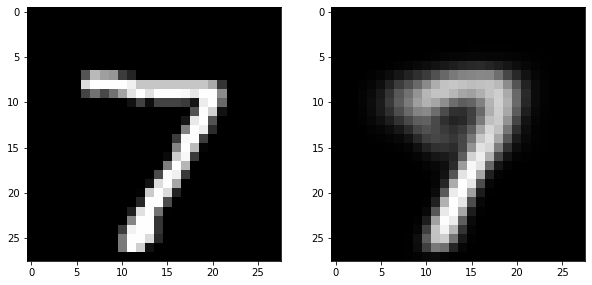

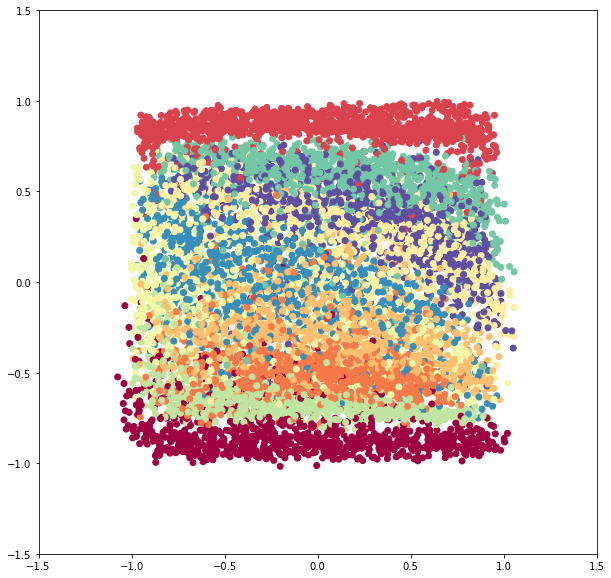

11 0.0004352570960919061 0.02377930137450798
12 0.00043141303310791616 0.023464080547324767
13 0.00042841194967428844 0.02322303149075554
14 0.00042467661102612816 0.023099103903832338
15 0.0004223764729996523 0.023552198543216284
16 0.00041876625219980867 0.023884874182387283
17 0.00041830375169714287 0.023309072797981122
18 0.000415865408629179 0.023491422193475997
19 0.00041220154613256447 0.02331231322925026
20 0.0004113006109992662 0.023360138407911357


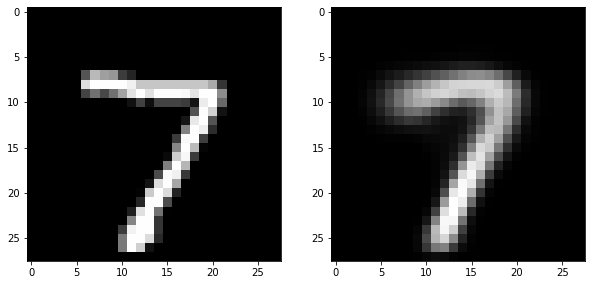

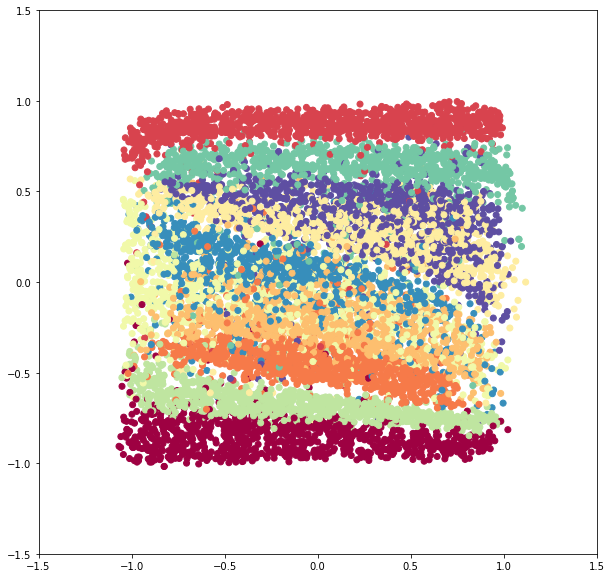

21 0.0004097962021827699 0.02364465746933374
22 0.0004099417154987651 0.023754232464887844
23 0.000407370839516322 0.023300583373172024
24 0.0004059732812146345 0.022941088214659462
25 0.00040601177016894014 0.02341763466929856
26 0.0004036166603366532 0.023364732458521
27 0.0004041494814058142 0.023312300991136046
28 0.00040231641108791013 0.022877587103686585
29 0.00040259502256910024 0.023471525034156088
30 0.00039966619039575257 0.023275428597395793


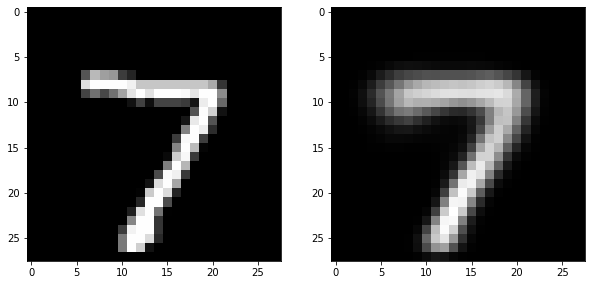

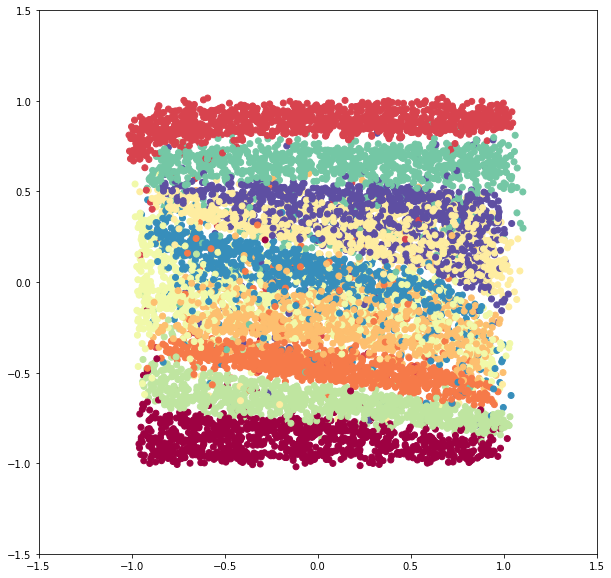

31 0.0003998874651889006 0.023292259304239726
32 0.0003998470343649386 0.023590391832061658
33 0.00039942099303007147 0.022724103417616492
34 0.0003970771143833795 0.022792398126218645
35 0.00039750580713152875 0.023468973332295973
36 0.0003960154704749584 0.02328198760474166
37 0.00039671050906181336 0.022538419390400757
38 0.000395855611562729 0.023083907391388006
39 0.0003939243080715339 0.023340942454152403
40 0.0003946159323056539 0.02321619706484266


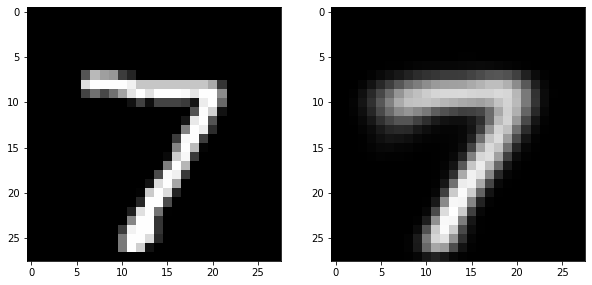

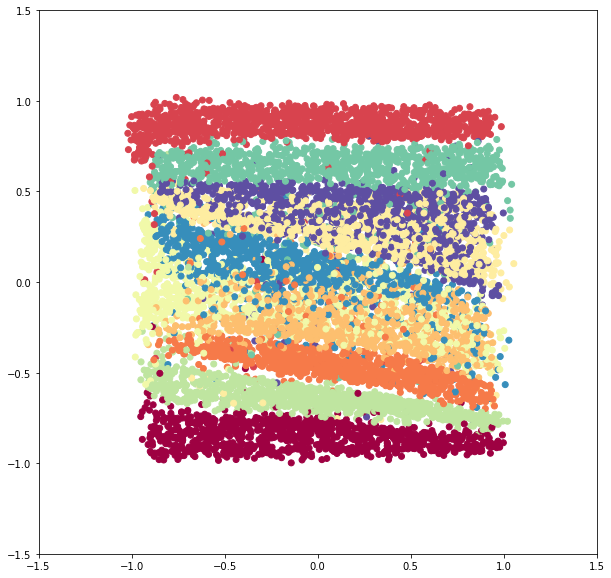

41 0.00039458965385953584 0.023355590512815376
42 0.000394354213029146 0.02248522855293827
43 0.0003923353066047032 0.02291971356117021
44 0.00039252599974473325 0.02308121166778163
45 0.00039309212441245706 0.02370451555881923
46 0.0003924369407196839 0.022647336919824727
47 0.0003910873954494791 0.022554804981587986
48 0.0003912894246478876 0.02292790582564216
49 0.00039142528002460814 0.022911585546054016
50 0.0003904683177669842 0.022961809070774924


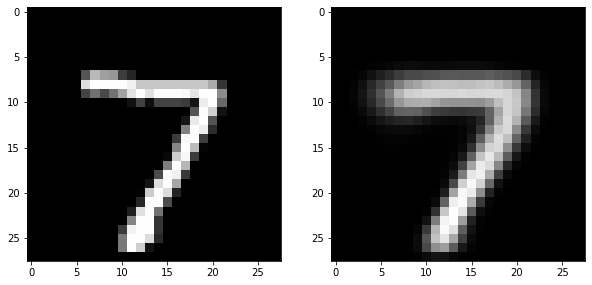

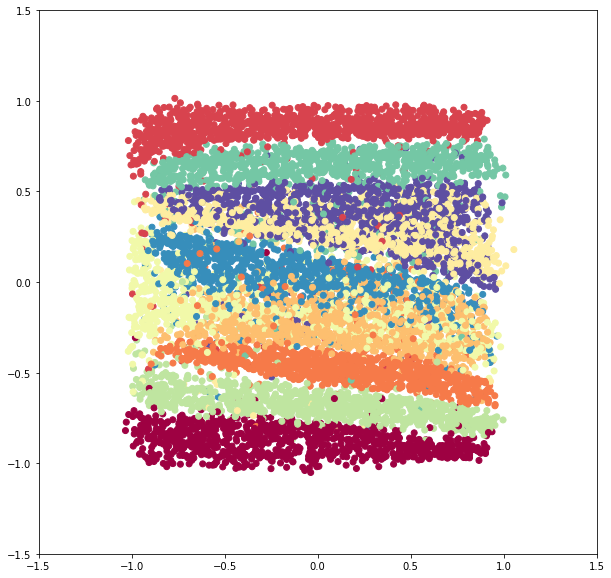

51 0.000389698396374782 0.02312354353693918
52 0.0003891895552476247 0.022418450706968674
53 0.0003911187335848809 0.02323467526644373
54 0.0003892442628741265 0.022726485788369902
55 0.0003898312516510486 0.022902220181121043
56 0.00038702437430620195 0.02307769964142634
57 0.0003878579919536909 0.02230832032776012
58 0.00038836491356293346 0.022782213991870897
59 0.00038839005182186745 0.022972243326231122
60 0.000386923577884833 0.023151349606581578


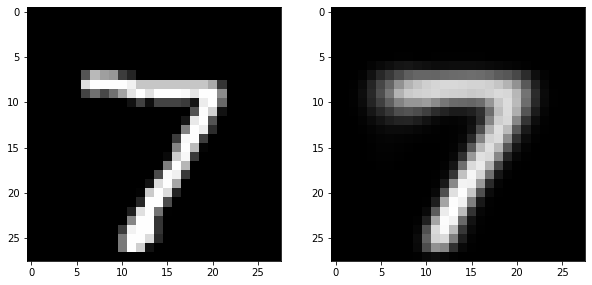

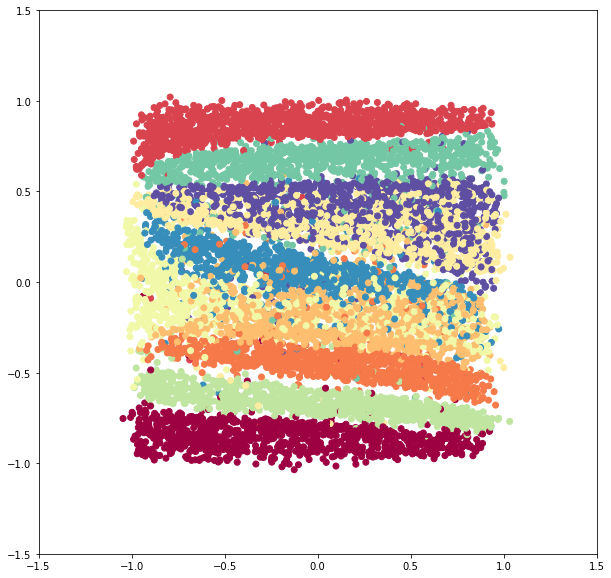

61 0.0003861295829216638 0.023147389358177353
62 0.00038746508881449686 0.022346208580195332
63 0.0003876426150401433 0.02336933728033742
64 0.0003854294029374919 0.022594095820697924
65 0.00038590018674731255 0.02306486321047853
66 0.00038538965682188674 0.02291633782331079
67 0.00038608563343683867 0.023005593588914925
68 0.0003847701373199622 0.022677667995397086
69 0.00038433751563231154 0.022929292466765203
70 0.00038387149572372426 0.02298604325055124


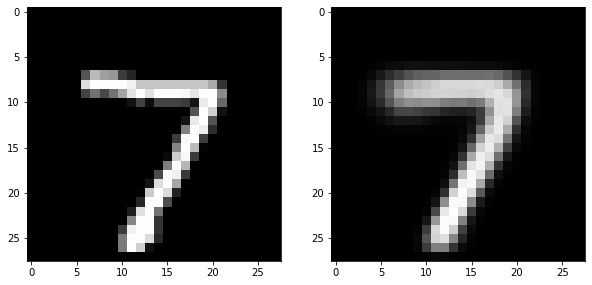

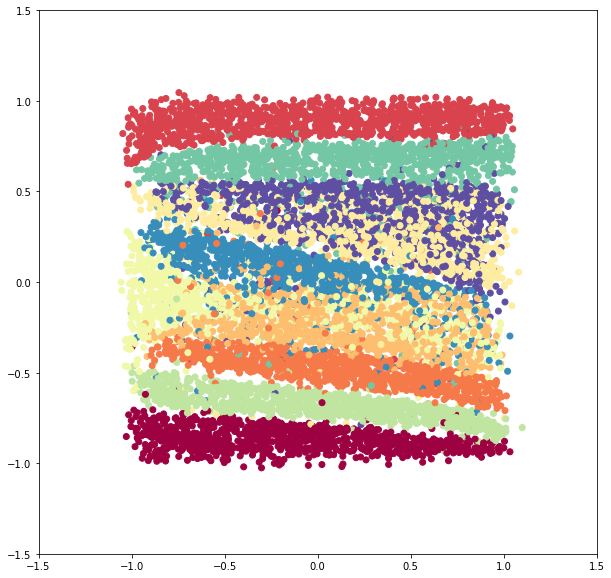

71 0.0003845388491948446 0.022417789703002945
72 0.00038474460641543096 0.022711348523513766
73 0.00038440131147702536 0.022633014350962904
74 0.0003834364702304207 0.022763258384796568
75 0.000383718806753556 0.023068083075288768
76 0.00038320899878938996 0.02348937031726677
77 0.00038240684395035086 0.023595586734505507
78 0.0003834283918142319 0.023002923076478436
79 0.0003820753472546737 0.022841456036764782
80 0.0003831261217594146 0.022654256354957915


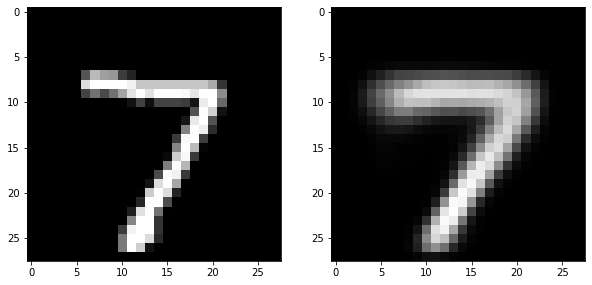

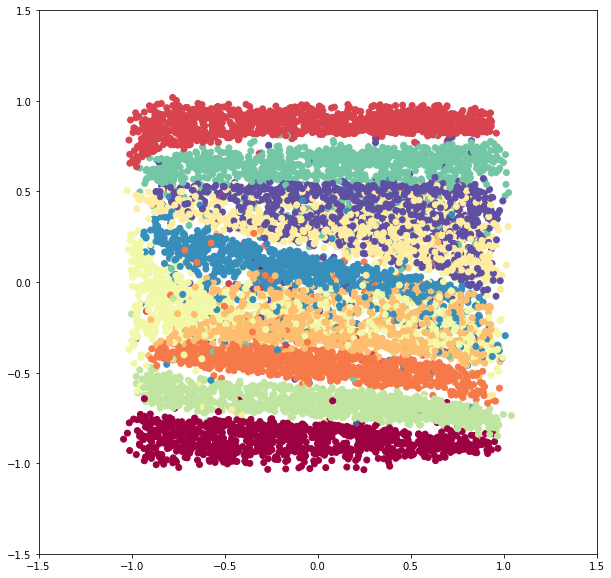

81 0.00038171630625923454 0.02232131913613778
82 0.0003812971211969852 0.023176755071781314
83 0.0003810458635290464 0.023134960245471983
84 0.0003817609133819741 0.022264519890847677
85 0.00038175858110189425 0.02257468588590717
86 0.00038096085637807843 0.022553673844201306
87 0.00038020503297448154 0.02273340167971655
88 0.00037966908166805883 0.022463062944741676
89 0.00038012023369471247 0.02282316789340478
90 0.0003810212023556233 0.023042487444730992


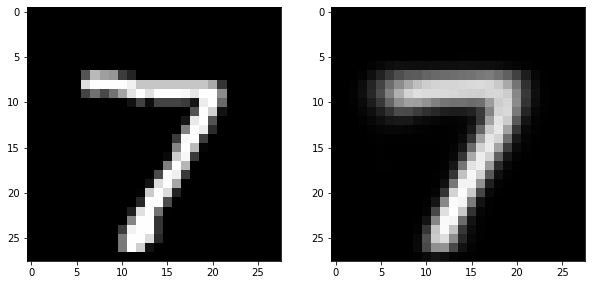

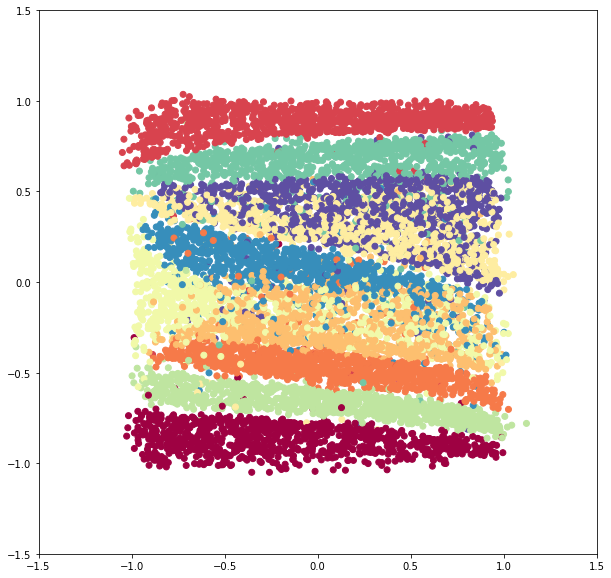

91 0.0003810076395670573 0.02342132134095263
92 0.00037945262293020895 0.02266480223225138
93 0.00038003447204828275 0.022656337884715952
94 0.0003786657912035783 0.02280067390324875
95 0.0003810578681528569 0.022595657211261246
96 0.00037890715648730597 0.02277493968713112
97 0.00037812785456577927 0.02337964384343487
98 0.0003789072814087072 0.02306499474714644
99 0.00037852030520637827 0.02314437179567334
100 0.00037755433643857616 0.023212331076399587


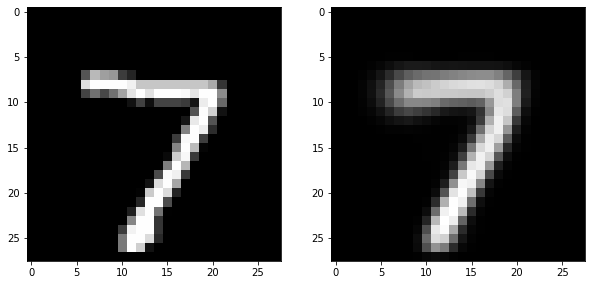

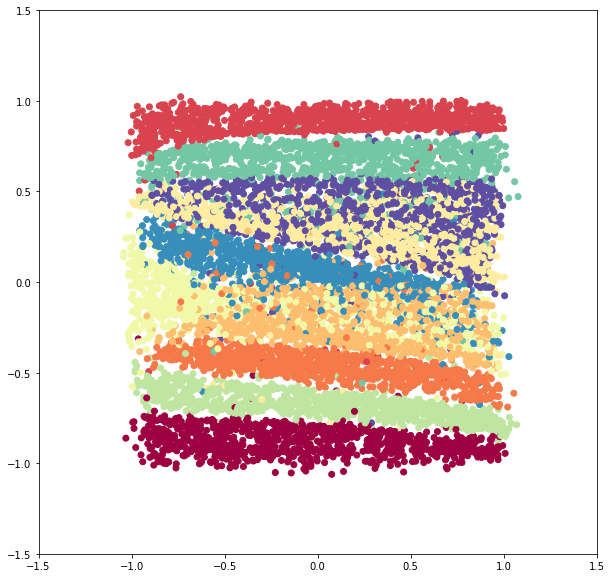

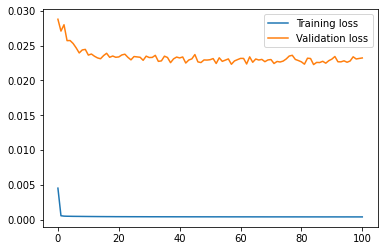

In [12]:
model = AE(16, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train(model, optimizer, 101, train_loader, test_loader, "unif", True)